In [1]:
#!sudo apt-get update --fix-missing
#!sudo apt install graphviz -y
#!pip install pydot

In [2]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter #https://docs.scipy.org/doc/scipy-0.10.0/reference/generated/scipy.signal.lfilter.html
from scipy import signal
import matplotlib.pyplot as plt

2024-02-21 22:56:54.130572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(924,)
(924,)
(1, 1024, 1)
(1, 1024, 1)


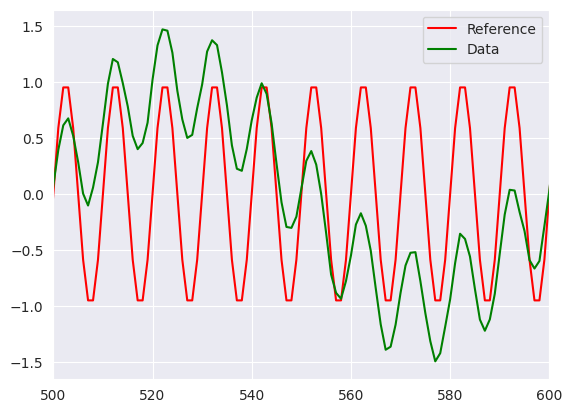

In [3]:
#Generate Data
f = 1
f2=0.1
Fs = f*10
N = 1024
noise  = np.random.normal(0,scale=0.02,size=N)
cW =2*np.cos(2*np.pi*f/Fs)
b=[1]
a=[5, -8.090, 5] #[5, 5*-cW ,5]

reference = np.sin(2 * np.pi * f * np.arange(N) / Fs)
data = 0.5*np.sin((2 * np.pi * f * np.arange(N) + np.pi/3)/ Fs) + noise +  np.sin(2 * np.pi * f2 * np.arange(N) / Fs)

#kernel_initializer=tf.keras.initializers.Constant(value=[5, -8.090, 5])
#resonator = tf.keras.layers.Conv1D(filters=1,kernel_size=3,activation=None,padding='causal',use_bias=False,name='resonator',kernel_initializer=kernel_initializer)
#data=resonator(tf.reshape(noise, (1, len(noise), 1)))
#plt.figure()
#freq, Pxx_den = signal.welch(np.squeeze(data), Fs, nperseg=1024)
#plt.semilogy(freq, Pxx_den,label='Estimated Resonator Data Spectrum')
#w, h = signal.freqz(1,a=a,fs=Fs)
#plt.semilogy(w, abs(h), 'r',label='True Resonator Spectrum')
#plt.xlabel('frequency [Hz]')
#plt.ylabel('PSD [V**2/Hz]')
#plt.legend()
#plt.show()

#plt.plot(np.squeeze(data),label='Resonator Data')
plt.plot(reference,label='Reference',c='r')
plt.plot(data,label='Data',c='g')
plt.legend()
plt.xlim([500,600])



S=N#-100 #3000
B=1#int(N/S)
print(reference[0:-100].shape)
print(reference[100:].shape)
x_train=np.reshape(reference,(B,S,1))
y_train=np.reshape(data,(B,S,1))
print(x_train.shape)
print(y_train.shape)

2024-02-21 22:56:55.557811: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: UNKNOWN ERROR (34)


[-0.31822777  0.4212638   0.25682223]
[5, -8.09, 5]


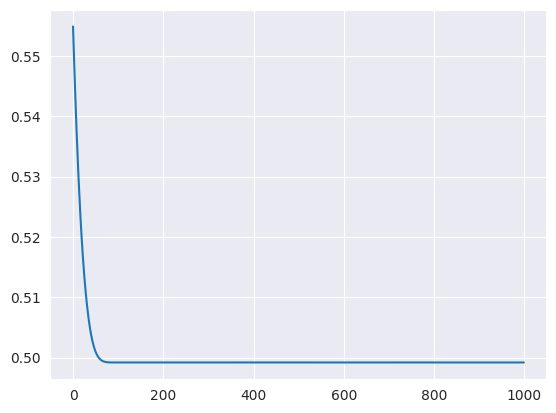

In [4]:
input = tf.keras.Input(shape=(S,1),name='data')
kernel_initializer=None #tf.keras.initializers.Constant(value=[5, -8.090, 5])
conv = tf.keras.layers.Conv1D(filters=1,kernel_size=3,activation=None,padding='causal',use_bias=False,name='Conv1',
                              kernel_initializer=kernel_initializer)(input)
#residue= tf.keras.layers.Subtract(name='Subtract')([input, conv])
model = tf.keras.Model(inputs=input,outputs=conv)
tf.keras.utils.plot_model(model, show_shapes=True)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-3), loss=tf.keras.losses.MeanSquaredError())
history=model.fit(x_train, y_train,epochs=1000,shuffle=True,verbose=0)
plt.plot(history.history['loss'])
a_hat=np.squeeze(model.layers[1].get_weights()[0])
print(a_hat)
print(a)


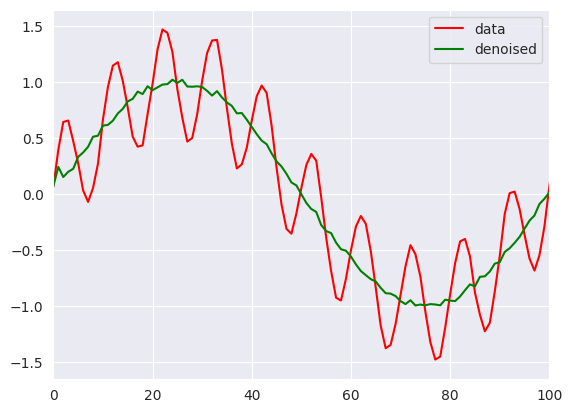

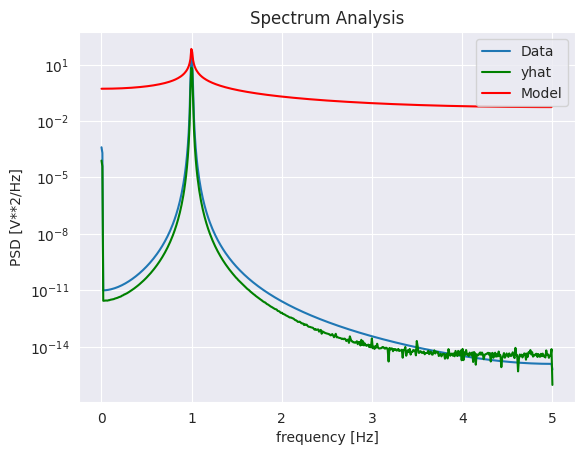

In [5]:
yhat=np.squeeze(model(x_train)) #predict(batched,verbose=0)
denoised=data-yhat
plt.plot(data,label='data',c='r')
plt.plot(denoised,label='denoised',c='g')
plt.legend()
plt.xlim([0,100])


plt.figure()
freq, Pxx_den = signal.welch(reference, Fs, nperseg=1024)
plt.semilogy(freq, Pxx_den,label='Data')

freq, Pxx_den = signal.welch(yhat, Fs, nperseg=1024)
plt.semilogy(freq, Pxx_den,label='yhat',c='g')


w, h = signal.freqz(b,a=a,fs=Fs)
plt.semilogy(w, abs(h), 'r',label='Model')

plt.title('Spectrum Analysis')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.show()

# Adaptive Noise Canceler

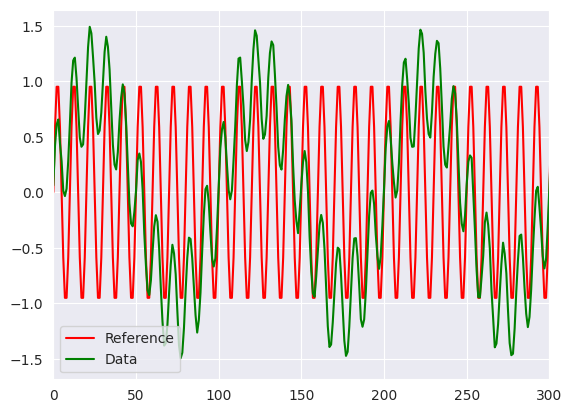

In [6]:
#Generate Data
f = 1
f2=0.1
Fs = f*10
N = 1024
noise  = np.random.normal(0,scale=0.02,size=N)
reference = np.sin(2 * np.pi * f * np.arange(N) / Fs)
data = 0.5*np.sin((2 * np.pi * f * np.arange(N) + np.pi/3)/ Fs) + noise +  np.sin(2 * np.pi * f2 * np.arange(N) / Fs)

#plt.plot(np.squeeze(data),label='Resonator Data')
plt.plot(reference,label='Reference',c='r')
plt.plot(data,label='Data',c='g')
plt.legend()
plt.xlim([0,300])

S=N
B=1
x_train=np.reshape(reference,(B,S,1))
y_train=np.reshape(data,(B,S,1))

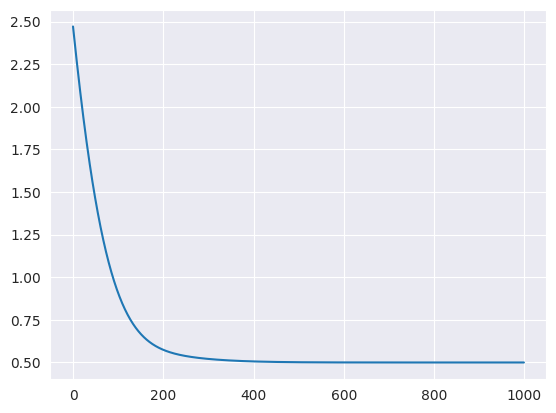

In [7]:
#Train
ref = tf.keras.Input(shape=(S,1),name='ref')
rec = tf.keras.Input(shape=(S,1),name='rec')
conv = tf.keras.layers.Conv1D(filters=1,kernel_size=3,activation=None,padding='causal',use_bias=False,name='Conv1')(ref)
denoised = tf.keras.layers.Subtract()([rec,conv])
model = tf.keras.Model(inputs=[ref,rec],outputs=[conv,denoised])
loss={'Conv1': tf.keras.losses.MeanSquaredError()}
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-3), loss=loss)
tf.keras.utils.plot_model(model, show_shapes=False)
inputs={'ref':x_train,'rec':y_train}
history=model.fit(inputs, y_train,epochs=1000,shuffle=True,verbose=0)
plt.plot(history.history['loss'])

(0.0, 100.0)

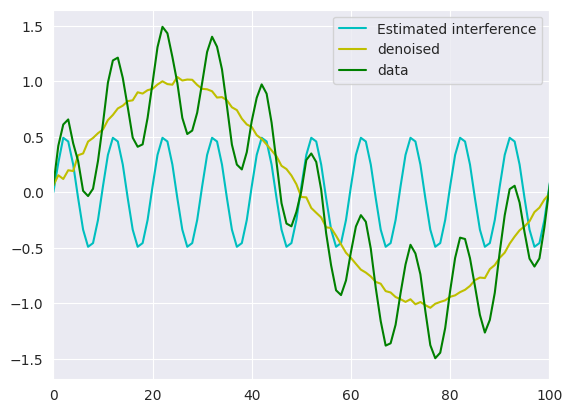

In [8]:
#Denoise and check results
out=model(inputs)
plt.plot(np.squeeze(out[0]),label='Estimated interference',c='c')
plt.plot(np.squeeze(out[1]),label='denoised',c='y')
plt.plot(data,label='data',c='g')
plt.legend()
plt.xlim([0,100])

# Adaptive Line Enhancement

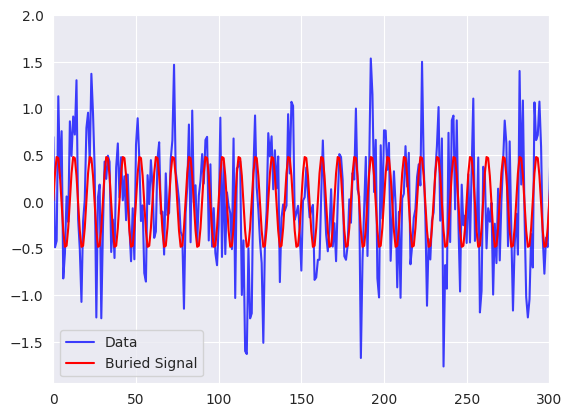

In [9]:

#Generate Data
f = 3
Fs = f*10
delay=10
N = 1024*2 + delay
noise  = np.random.normal(0,scale=0.5,size=N)
signal = 0.5*np.sin((2 * np.pi * f * np.arange(N) + np.pi/3)/ Fs)
data = signal + noise

#plt.plot(np.squeeze(data),label='Resonator Data')
plt.plot(data,label='Data',c='b',alpha=0.75)
plt.plot(signal,label='Buried Signal',c='r')
plt.legend()
plt.xlim([0,300])


S=N-delay
B=1
x_train=np.reshape(data[0:-delay],(B,S,1))
y_train=np.reshape(data[delay:],(B,S,1))
#x_train=np.reshape(data,(B,S,1))
#y_train=np.reshape(data,(B,S,1))

[0.03484394 0.19460888 0.2890666 ]


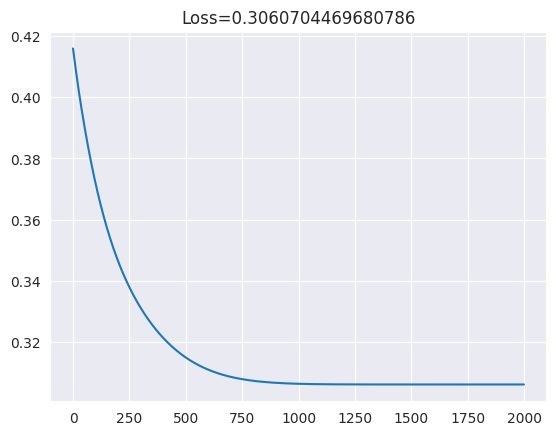

In [10]:
#Train
input = tf.keras.Input(shape=(S,1),name='input')
conv = tf.keras.layers.Conv1D(filters=1,kernel_size=3,activation=None,padding='causal',use_bias=False,name='Conv1')(input)
model = tf.keras.Model(inputs=input,outputs=conv)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss=tf.keras.losses.MeanSquaredError())
tf.keras.utils.plot_model(model, show_shapes=False)
history=model.fit(x_train, y_train,epochs=2000,shuffle=True,verbose=0)
plt.plot(history.history['loss'])
plt.title("Loss=%s"%history.history['loss'][-1])
a_hat=np.squeeze(model.layers[1].get_weights()[0])
print(a_hat)

(1858.0, 2058.0)

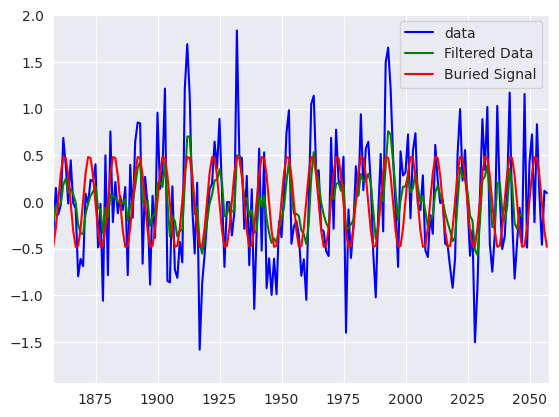

In [11]:
#Denoise and check results
out=model(x_train)
plt.plot(data,label='data',c='b')
plt.plot(np.squeeze(out),label='Filtered Data',c='g')
plt.plot(signal,label='Buried Signal',c='r')
plt.legend()
plt.xlim([N-200,N])

# Adaptive Line Enhancer: Two Independen channels

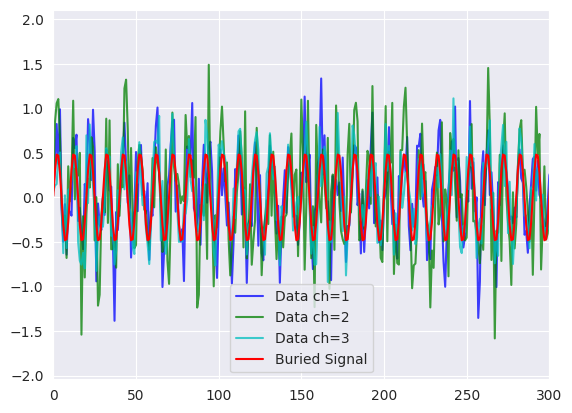

In [12]:
#Generate Data
f = 3
Fs = f*10
delay=10
N = 1024*2 + delay
noise  = np.random.normal(0,scale=(0.3,0.5,0.25),size=(N,3))
signal = 0.5*np.sin((2 * np.pi * f * np.arange(N) + np.pi/3)/ Fs)
data = signal[:,np.newaxis] + noise

#plt.plot(np.squeeze(data),label='Resonator Data')
plt.plot(data[:,0],label='Data ch=1',c='b',alpha=0.75)
plt.plot(data[:,1],label='Data ch=2',c='g',alpha=0.75)
plt.plot(data[:,2],label='Data ch=3',c='c',alpha=0.75)
plt.plot(signal,label='Buried Signal',c='r')
plt.legend()
plt.xlim([0,300])


S=N-delay
B=1
x_train1=np.reshape(data[0:-delay,0],(B,S,1))
x_train2=np.reshape(data[0:-delay,1],(B,S,1))
x_train3=np.reshape(data[0:-delay,2],(B,S,1))
y_train=np.reshape(data[delay:,-1],(B,S,1))

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ch1 (InputLayer)               [(None, 2048, 1)]    0           []                               
                                                                                                  
 ch2 (InputLayer)               [(None, 2048, 1)]    0           []                               
                                                                                                  
 ch3 (InputLayer)               [(None, 2048, 1)]    0           []                               
                                                                                                  
 Conv1 (Conv1D)                 (None, 2048, 1)      3           ['ch1[0][0]']                    
                                                                                            

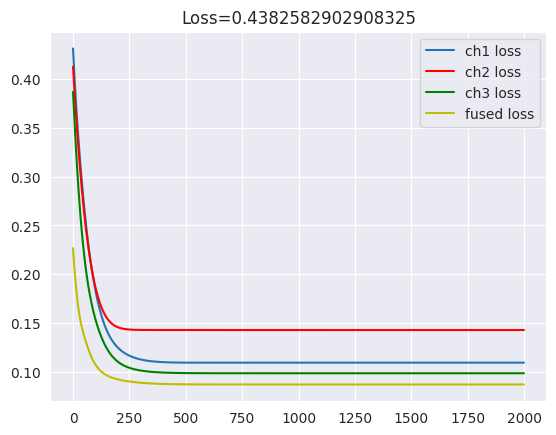

In [13]:
#Train
ch1 = tf.keras.Input(shape=(S,1),name='ch1')
activation='linear'
conv1 = tf.keras.layers.Conv1D(filters=1,kernel_size=3,activation=activation,padding='causal',use_bias=False,name='Conv1')(ch1)
ch2 = tf.keras.Input(shape=(S,1),name='ch2')
conv2 = tf.keras.layers.Conv1D(filters=1,kernel_size=3,activation=activation,padding='causal',use_bias=False,name='Conv2')(ch2)
ch3 = tf.keras.Input(shape=(S,1),name='ch3')
conv3 = tf.keras.layers.Conv1D(filters=1,kernel_size=3,activation=activation,padding='causal',use_bias=False,name='Conv3')(ch3)

concat=tf.keras.layers.Concatenate()([conv1,conv2,conv3])
fused= tf.keras.layers.Dense(1,activation='linear',name='fused')(concat)
model = tf.keras.Model(inputs=[ch1,ch2,ch3],outputs=[conv1,conv2,conv3,fused])


loss={'Conv1':tf.keras.losses.MeanSquaredError(),'Conv2':tf.keras.losses.MeanSquaredError(),
      'Conv3':tf.keras.losses.MeanSquaredError(),'fused':tf.keras.losses.MeanSquaredError()}
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-3),loss=loss)


tf.keras.utils.plot_model(model, show_shapes=False)
history=model.fit([x_train1,x_train2,x_train3],y_train,epochs=2000,shuffle=True,verbose=0)
plt.plot(history.history['Conv1_loss'],label='ch1 loss')
plt.plot(history.history['Conv2_loss'],label='ch2 loss',c='r')
plt.plot(history.history['Conv3_loss'],label='ch3 loss',c='g')
plt.plot(history.history['fused_loss'],label='fused loss',c='y')
plt.legend()
plt.title("Loss=%s"%history.history['loss'][-1])


print(model.summary())

(1858.0, 2058.0)

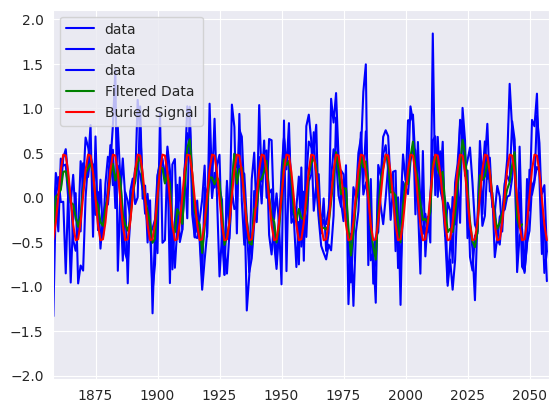

In [14]:
#Denoise and check results
out=model([x_train1,x_train2,x_train3])
out=np.squeeze(out[-1])
#print(out.shape)
#out = np.mean(out,axis=-1)
plt.plot(data,label='data',c='b')
plt.plot(out,label='Filtered Data',c='g')
plt.plot(signal,label='Buried Signal',c='r')
plt.legend()
plt.xlim([N-200,N])

# Adaptive Line Enhancer: 3 Independent channels Two Frequencies: Random Conv Init

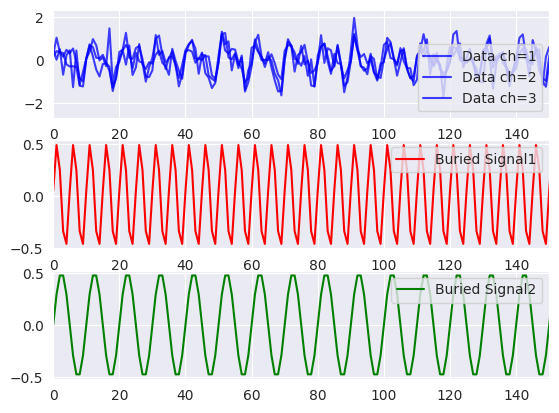

In [15]:
#Generate Data
Fs = 10
delay=10
N = 1024*2 + delay
noise  = np.random.normal(0,scale=(0.3,0.5,0.25),size=(N,3))
signal1 = 0.5*np.sin((2 * np.pi * 2 * np.arange(N) + np.pi/3)/ Fs)
signal2 = 0.5*np.sin((2 * np.pi * 1 * np.arange(N) )/ Fs)
data = signal1[:,np.newaxis] +  signal2[:,np.newaxis] + noise

#plt.plot(np.squeeze(data),label='Resonator Data')
plt.subplot(311)
plt.plot(data[:,0],label='Data ch=1',c='b',alpha=0.75)
plt.plot(data[:,1],label='Data ch=2',c='b',alpha=0.75)
plt.plot(data[:,2],label='Data ch=3',c='b',alpha=0.75)
plt.legend()
plt.xlim([0,150])

plt.subplot(312)
plt.plot(signal1,label='Buried Signal1',c='r')
plt.legend()
plt.xlim([0,150])

plt.subplot(313)
plt.plot(signal2,label='Buried Signal2',c='g')
plt.legend()
plt.xlim([0,150])


S=N-delay
B=1
x_train=np.reshape(data[0:-delay,:],(B,S,3))
y_train1=np.reshape(data[delay:,0],(B,S,1))
y_train2=np.reshape(data[delay:,1],(B,S,1))
y_train3=np.reshape(data[delay:,2],(B,S,1))
y_train=[y_train1,y_train2,y_train3]

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 2048, 3)]    0           []                               
                                                                                                  
 Conv1 (SeparableConv1D)        (None, 2048, 2)      15          ['data[0][0]']                   
                                                                                                  
 ch1 (Dense)                    (None, 2048, 1)      3           ['Conv1[0][0]']                  
                                                                                                  
 ch2 (Dense)                    (None, 2048, 1)      3           ['Conv1[0][0]']                  
                                                                                            

Text(0.5, 1.0, 'Losses')

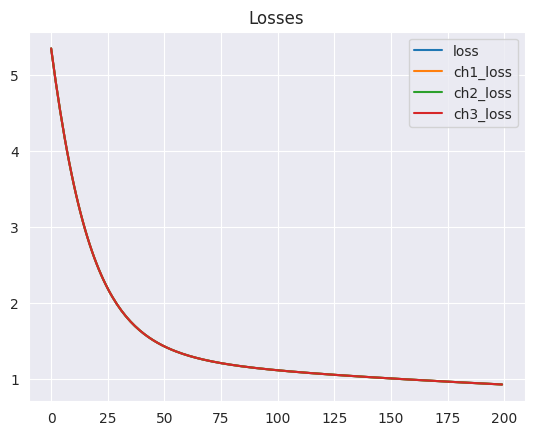

In [16]:
#Train
chs = tf.keras.Input(shape=(S,3),name='data')
activation='linear'
conv1 = tf.keras.layers.SeparableConv1D(filters=2,kernel_size=3,activation=activation,padding='causal',use_bias=False,name='Conv1')(chs)
out1 = tf.keras.layers.Dense(1,activation='linear',name='ch1')(conv1)
out2 = tf.keras.layers.Dense(1,activation='linear',name='ch2')(conv1)
out3 = tf.keras.layers.Dense(1,activation='linear',name='ch3')(conv1)
model = tf.keras.Model(inputs=chs,outputs=[out1,out2,out3])

loss={'ch1':tf.keras.losses.MeanSquaredError(),'ch2':tf.keras.losses.MeanSquaredError(),
      'ch3':tf.keras.losses.MeanSquaredError()}
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-3),loss=tf.keras.losses.MeanSquaredError())
print(model.summary())

tf.keras.utils.plot_model(model, show_shapes=False)
history=model.fit(x_train,y_train,epochs=200,shuffle=True,verbose=0)
for k in history.history.keys():
    if k.find('loss')>-1:
        plt.plot(history.history['loss'],label=k)
plt.legend()
plt.title("Losses")




(2048, 2)


(0.0, 150.0)

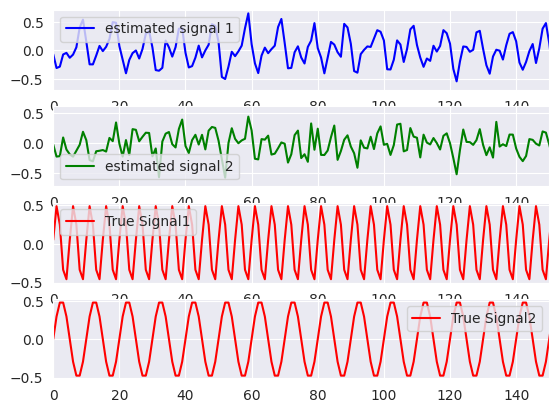

In [18]:
#Denoise and check results
conv1_model = tf.keras.Model(inputs=model.input,outputs=model.get_layer('Conv1').output)
filtered= conv1_model(x_train)
filtered=np.squeeze(filtered)
print(filtered.shape)

plt.subplot(411)
plt.plot(filtered[:,0],label='estimated signal 1',c='b')
plt.legend()
plt.xlim([0,150])

plt.subplot(412)
plt.plot(filtered[:,1],label='estimated signal 2',c='g')
plt.legend()
plt.xlim([0,150])

plt.subplot(413)
plt.plot(signal1,label='True Signal1',c='r')
plt.legend()
plt.xlim([0,150])

plt.subplot(414)
plt.plot(signal2,label='True Signal2',c='r')
plt.legend()
plt.xlim([0,150])




In [17]:
#Train
chs = tf.keras.Input(shape=(S,3),name='data')
activation='linear'
conv1 = tf.keras.layers.SeparableConv1D(filters=2,kernel_size=3,activation=activation,padding='causal',use_bias=False,name='Conv1')(chs)
out1 = tf.keras.layers.Dense(1,activation='linear',name='ch1')(conv1)
out2 = tf.keras.layers.Dense(1,activation='linear',name='ch2')(conv1)
out3 = tf.keras.layers.Dense(1,activation='linear',name='ch3')(conv1)
model = tf.keras.Model(inputs=chs,outputs=[out1,out2,out3])

loss={'ch1':tf.keras.losses.MeanSquaredError(),'ch2':tf.keras.losses.MeanSquaredError(),
      'ch3':tf.keras.losses.MeanSquaredError()}
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-3),loss=tf.keras.losses.MeanSquaredError())
print(model.summary())

tf.keras.utils.plot_model(model, show_shapes=False)
history=model.fit(x_train,y_train,epochs=200,shuffle=True,verbose=0)
for k in history.history.keys():
    if k.find('loss')>-1:
        plt.plot(history.history['loss'],label=k)
plt.legend()
plt.title("Losses")